In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import os
from skimage import measure
from scipy import interpolate
from pathlib import Path
import pandas as pd
from radiomicsutil.voi import find_contours, getMask, calc_vol, calc_mesh, smooth_mesh, plot_mesh, plot_mesh3d
# 指定.npy檔案的路徑
npy_file_path = './ISD-0003/imgs.npy'

# 使用np.load()方法讀取.npy檔案
image_data = np.load(npy_file_path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# 使用os.path.basename获取文件名部分
file_name = os.path.basename(os.path.dirname(npy_file_path))
print(file_name)
# 使用字符串分割方法分割文件名
parts = file_name.split('-')

# 提取0003并存储到变量中
if len(parts) >= 2:
    identifier = parts[1]

print(identifier)  # 输出变量identifier


ISD-0003
0003


In [3]:
def getLargestContour(img: np.array):
    img = onlyContours(img)
   # print(img)
    #print(dff)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #width = 0
    #high = 0
    if not contours:
        return None 
    
    areas = [cv2.contourArea(cnt) for cnt in contours]
    max_idx = np.argmax(areas)
    largest_contour = contours[max_idx]
    
    
    mask = np.zeros((800, 800), dtype=np.uint8)
    #mask = cv2.drawContours(mask, [largest_contour], 0, 255, 10)
    cv2.drawContours(mask, [largest_contour], 0, 255, thickness=cv2.FILLED)
   
    #img =  cv2.bitwise_or(img, (np.zeros((800, 800), dtype=np.uint8)))
    return np.array(mask)
def onlyContours(img: np.array):
    rows, cols, els = img.shape
    bin = np.zeros((rows, cols), dtype='uint8')
    for i in range(rows):
        for j in range(cols):
            if (img[i,j,0] == img[i,j,1] == img[i,j,2] ):
                bin[i,j] = 0
            elif((img[i,j,2]-img[i,j,1]) > 50): 
                bin[i,j] = 255
            else: bin[i,j] = 0

    return bin

In [4]:
masks = list()
for idx in range(len(image_data)):
    image = getLargestContour(image_data[idx])
    masks.append(image)

C:\Users\User\AppData\Local\Temp\ipykernel_16244\2204506995.py:29: RuntimeWarning: overflow encountered in scalar subtract
  elif((img[i,j,2]-img[i,j,1]) > 50):


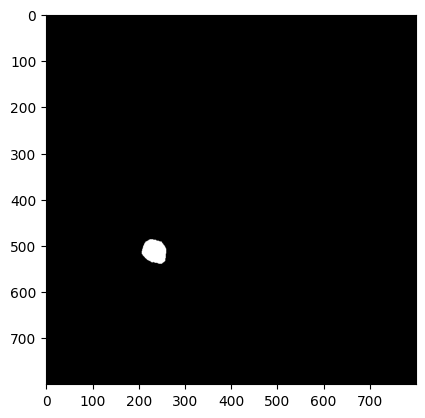

In [5]:
plt.imshow(masks[0], cmap='gray')  # 使用灰度色彩映射
# plt.axis('off')  # 不顯示坐標軸
plt.show()

In [6]:
with open("./ISD-0003_slicelocations_half.pkl", "rb") as f:
        slice_locations = pickle.load(f)

In [7]:
sorted_indices = np.argsort(slice_locations)
slice_locations.sort()
masks_sorted = [masks[i] for i in sorted_indices]

In [8]:
# Pixel spacing and slice thickness (in mm)
px_spacing = 0.6328125
py_spacing = 0.6328125
slice_thickness = 5.0

In [9]:
# Create 3D grid for interpolation
z = np.array(slice_locations)
y = np.arange(0, masks[0].shape[0] * px_spacing, px_spacing)
x = np.arange(0, masks[0].shape[1] * px_spacing, px_spacing)

In [10]:
# Convert sorted masks to binary and stack along the z-axis
masks_bin = np.array([(mask > 0).astype(int) for mask in masks_sorted])

In [11]:
# Create 3D grid for the masks
z_mask = np.arange(z.min(), z.max() + slice_thickness, slice_thickness)
x_mask, y_mask, z_mask = np.meshgrid(x, y, z_mask, indexing='ij')

In [16]:
from scipy import interpolate
# Create the interpolator function
interpolator = interpolate.RegularGridInterpolator((x, y, z), np.moveaxis(masks_bin, 0, -1), method='nearest', bounds_error=False, fill_value=0)

# Interpolate to fill missing slices
vol = interpolator((x_mask, y_mask, z_mask))

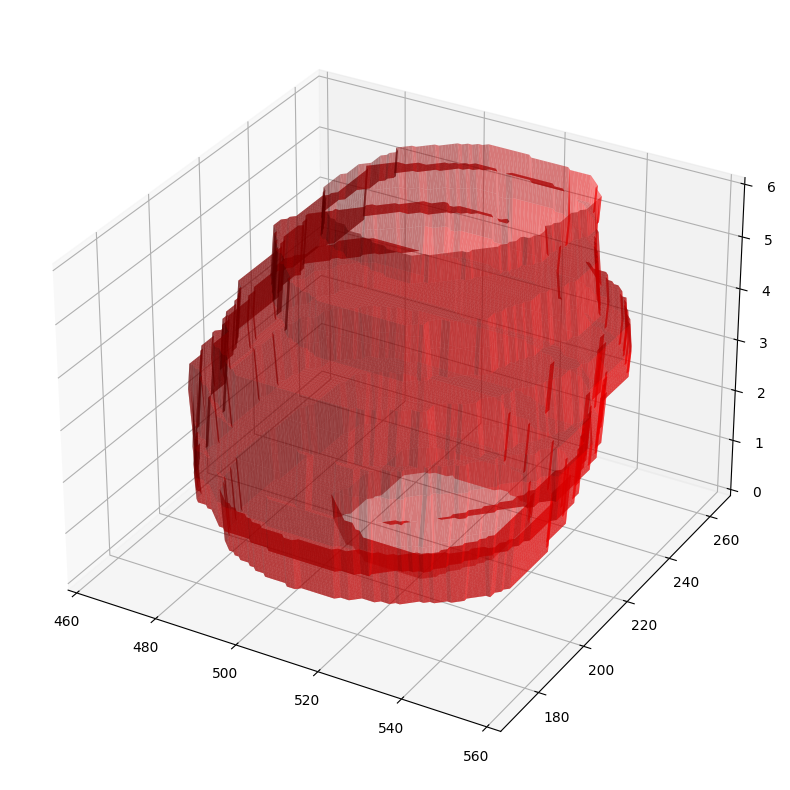

In [17]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, _, _ = measure.marching_cubes(vol, level=0.5)

# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                linewidth=0.2, antialiased=True, color='red', alpha=0.5)

plt.show()

In [21]:
# Calculate the volume in cubic millimeters
pixel_volume = px_spacing ** 2 * slice_thickness
total_volume = np.sum(vol) * pixel_volume

total_volume

59453.055725097656

In [22]:
from radiomicsutil.threed import ThreedMorphologyFeaturesExtractor
tumor_extractor = ThreedMorphologyFeaturesExtractor(vol)

In [23]:
threed_morphology_p = tumor_extractor.all('p')

Use voxel to estimate volume...


In [24]:
threed_morphology_p['ISDnumber'] = pd.Series([identifier])

In [25]:
threed_morphology_p.to_csv('./ISD-0003_VALUE.csv',index=False)

'./ISD-0003/imgs.npy'

C:\Users\User\AppData\Local\Temp\ipykernel_16244\2627570338.py:37: RuntimeWarning: overflow encountered in scalar subtract
  elif((img[i,j,2]-img[i,j,1]) > 50):


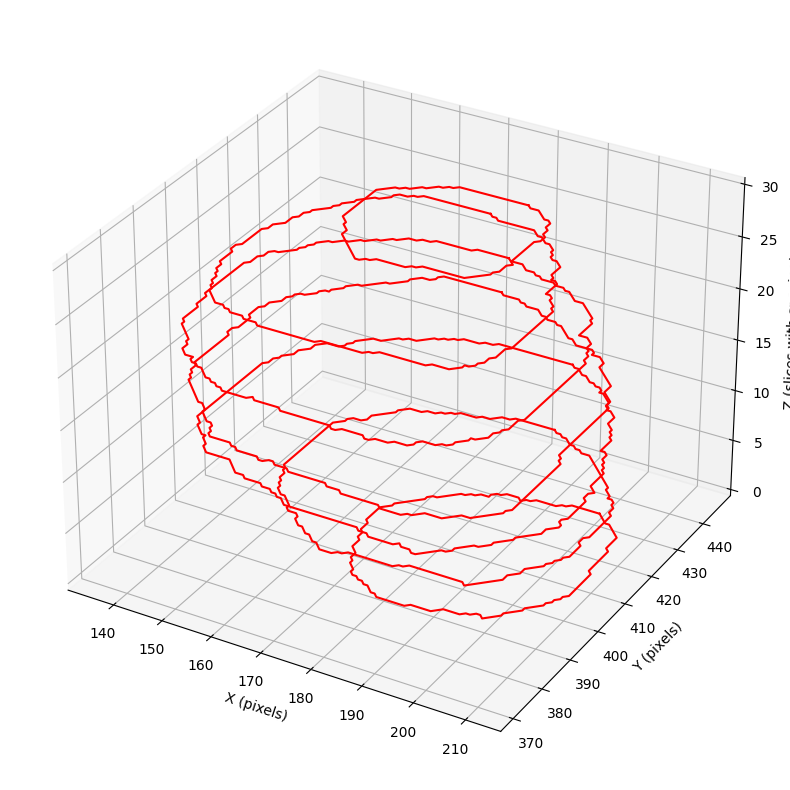

In [30]:
# 導入必要的庫
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 讀取影像數據
npy_file_path = './ISD-0003/imgs.npy'
image_data = np.load(npy_file_path)

# 設定像素間距和切片厚度
px_spacing = 0.8  # 根據實際數據調整
py_spacing = 0.8  # 根據實際數據調整
slice_thickness = 5.0  # 根據實際數據調整

# 定義函數：提取最大輪廓並生成掩膜
def getLargestContour(img: np.array):
    img = onlyContours(img)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None 
    areas = [cv2.contourArea(cnt) for cnt in contours]
    max_idx = np.argmax(areas)
    largest_contour = contours[max_idx]
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    cv2.drawContours(mask, [largest_contour], 0, 255, thickness=cv2.FILLED)
    return mask

# 定義輔助函數：生成二值化影像
def onlyContours(img: np.array):
    rows, cols, els = img.shape
    bin = np.zeros((rows, cols), dtype='uint8')
    for i in range(rows):
        for j in range(cols):
            if (img[i,j,0] == img[i,j,1] == img[i,j,2]):
                bin[i,j] = 0
            elif((img[i,j,2]-img[i,j,1]) > 50): 
                bin[i,j] = 255
            else:
                bin[i,j] = 0
    return bin

# 生成每張影像的最大輪廓掩膜
masks = list()
for idx in range(len(image_data)):
    image = getLargestContour(image_data[idx])
    if image is not None:
        masks.append(image)

# 創建立體圖並逐層繪製掩膜
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 繪製每一層的輪廓，並在Z軸上設置空隙
z_spacing = slice_thickness   # 為每個切片之間添加額外的空隙

for i, mask in enumerate(masks):
    contours = measure.find_contours(mask, 0.5)
    for contour in contours:
        ax.plot3D(contour[:, 1] * px_spacing, contour[:, 0] * py_spacing, i * z_spacing, 'red')

# 設置坐標軸標籤
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_zlabel('Z (slices with spacing)')

# 顯示立體圖
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_16244\1931154871.py:37: RuntimeWarning: overflow encountered in scalar subtract
  elif((img[i,j,2]-img[i,j,1]) > 50):


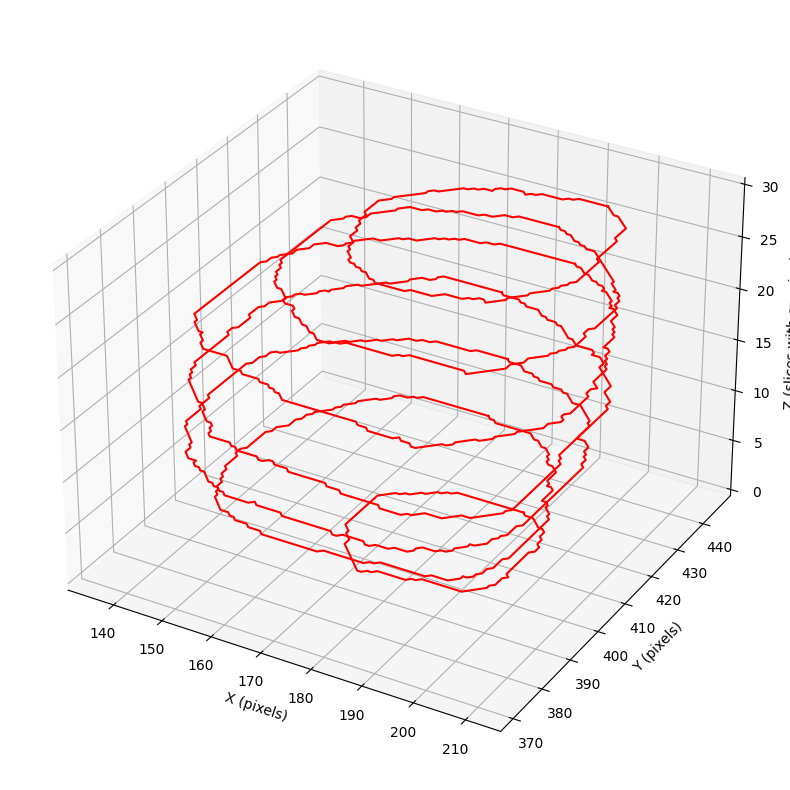

In [29]:
# 導入必要的庫
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 讀取影像數據
npy_file_path = './ISD-0003/imgs.npy'
image_data = np.load(npy_file_path)

# 設定像素間距和切片厚度
px_spacing = 0.8  # 根據實際數據調整
py_spacing = 0.8  # 根據實際數據調整
slice_thickness = 5.0  # 根據實際數據調整

# 定義函數：提取最大輪廓並生成掩膜
def getLargestContour(img: np.array):
    img = onlyContours(img)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None 
    areas = [cv2.contourArea(cnt) for cnt in contours]
    max_idx = np.argmax(areas)
    largest_contour = contours[max_idx]
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    cv2.drawContours(mask, [largest_contour], 0, 255, thickness=cv2.FILLED)
    return mask

# 定義輔助函數：生成二值化影像
def onlyContours(img: np.array):
    rows, cols, els = img.shape
    bin = np.zeros((rows, cols), dtype='uint8')
    for i in range(rows):
        for j in range(cols):
            if (img[i,j,0] == img[i,j,1] == img[i,j,2]):
                bin[i,j] = 0
            elif((img[i,j,2]-img[i,j,1]) > 50): 
                bin[i,j] = 255
            else:
                bin[i,j] = 0
    return bin

# 生成每張影像的最大輪廓掩膜
masks = list()
for idx in range(len(image_data)):
    image = getLargestContour(image_data[idx])
    if image is not None:
        masks.append(image)

# 創建立體圖並逐層繪製掩膜
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 計算倒序的 Z 軸位置，將圖像顛倒
z_values = np.arange(len(masks)) * slice_thickness
z_values = z_values[::-1]  # 將Z軸位置反轉

# 繪製每一層的輪廓，並使用反轉的Z軸位置
for i, (mask, z_value) in enumerate(zip(masks, z_values)):
    contours = measure.find_contours(mask, 0.5)
    for contour in contours:
        ax.plot3D(contour[:, 1] * px_spacing, contour[:, 0] * py_spacing, z_value, 'red')

# 設置坐標軸標籤
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_zlabel('Z (slices with spacing)')

# 顯示立體圖
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import os
from skimage import measure
from scipy import interpolate
from pathlib import Path
import pandas as pd
from radiomicsutil.voi import find_contours, getMask, calc_vol, calc_mesh, smooth_mesh, plot_mesh, plot_mesh3d
# 指定.npy檔案的路徑
npy_file_path = './ISD-0003/imgs.npy'

# 使用np.load()方法讀取.npy檔案
image_data = np.load(npy_file_path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
# 使用os.path.basename获取文件名部分
file_name = os.path.basename(os.path.dirname(npy_file_path))
print(file_name)
# 使用字符串分割方法分割文件名
parts = file_name.split('-')

# 提取0003并存储到变量中
if len(parts) >= 2:
    identifier = parts[1]

print(identifier)  # 输出变量identifier


ISD-0003
0003


In [ ]:
def getLargestContour(img: np.array):
    img = onlyContours(img)
   # print(img)
    #print(dff)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #width = 0
    #high = 0
    if not contours:
        return None 
    
    areas = [cv2.contourArea(cnt) for cnt in contours]
    max_idx = np.argmax(areas)
    largest_contour = contours[max_idx]
    
    
    mask = np.zeros((800, 800), dtype=np.uint8)
    #mask = cv2.drawContours(mask, [largest_contour], 0, 255, 10)
    cv2.drawContours(mask, [largest_contour], 0, 255, thickness=cv2.FILLED)
   
    #img =  cv2.bitwise_or(img, (np.zeros((800, 800), dtype=np.uint8)))
    return np.array(mask)
def onlyContours(img: np.array):
    rows, cols, els = img.shape
    bin = np.zeros((rows, cols), dtype='uint8')
    for i in range(rows):
        for j in range(cols):
            if (img[i,j,0] == img[i,j,1] == img[i,j,2] ):
                bin[i,j] = 0
            elif((img[i,j,2]-img[i,j,1]) > 50): 
                bin[i,j] = 255
            else: bin[i,j] = 0

    return bin

In [ ]:
masks = list()
for idx in range(len(image_data)):
    image = getLargestContour(image_data[idx])
    masks.append(image)

C:\Users\User\AppData\Local\Temp\ipykernel_16244\2204506995.py:29: RuntimeWarning: overflow encountered in scalar subtract
  elif((img[i,j,2]-img[i,j,1]) > 50):


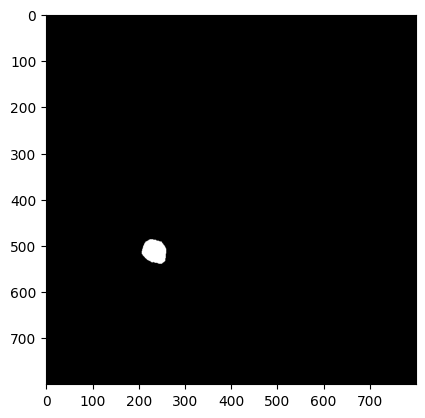

In [ ]:
plt.imshow(masks[0], cmap='gray')  # 使用灰度色彩映射
# plt.axis('off')  # 不顯示坐標軸
plt.show()

In [ ]:
with open("./ISD-0003_slicelocations_half.pkl", "rb") as f:
        slice_locations = pickle.load(f)

In [ ]:
sorted_indices = np.argsort(slice_locations)
slice_locations.sort()
masks_sorted = [masks[i] for i in sorted_indices]

In [ ]:
# Pixel spacing and slice thickness (in mm)
px_spacing = 0.6328125
py_spacing = 0.6328125
slice_thickness = 5.0

In [ ]:
# Create 3D grid for interpolation
z = np.array(slice_locations)
y = np.arange(0, masks[0].shape[0] * px_spacing, px_spacing)
x = np.arange(0, masks[0].shape[1] * px_spacing, px_spacing)

In [ ]:
# Convert sorted masks to binary and stack along the z-axis
masks_bin = np.array([(mask > 0).astype(int) for mask in masks_sorted])

In [ ]:
# Create 3D grid for the masks
z_mask = np.arange(z.min(), z.max() + slice_thickness, slice_thickness)
x_mask, y_mask, z_mask = np.meshgrid(x, y, z_mask, indexing='ij')

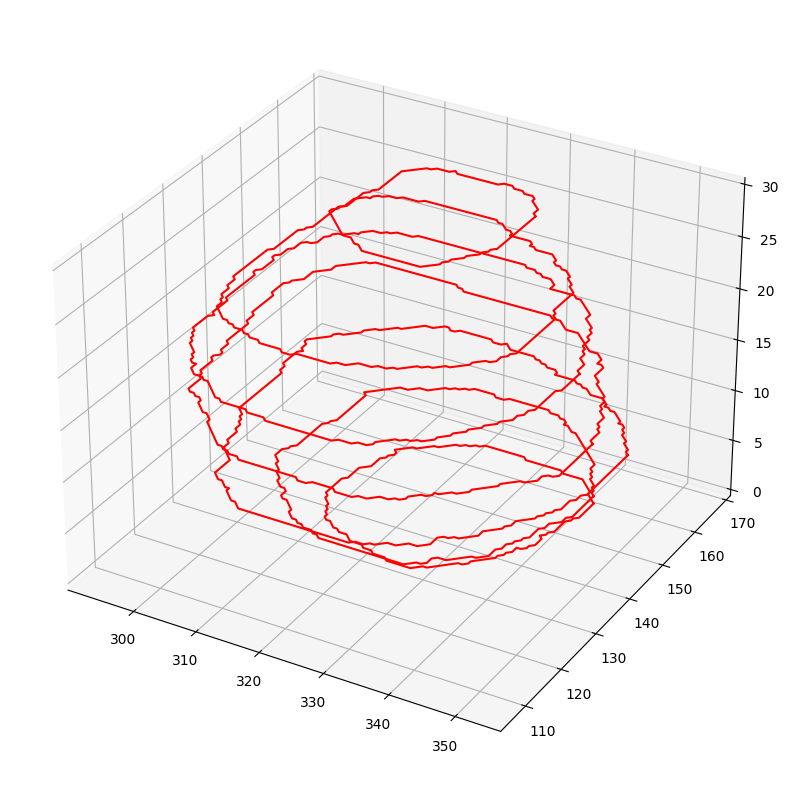

In [ ]:
# masks = list()
# for idx in range(len(image_data)):
#     image = getLargestContour(image_data[idx])
#     if image is not None:
#         masks.append(image)

# 創建立體圖並逐層繪製掩膜
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 繪製每一層的輪廓，並在Z軸上設置空隙
z_spacing = slice_thickness   # 為每個切片之間添加額外的空隙

for i, mask in enumerate(masks):
    contours = measure.find_contours(mask, 0.5)
    for contour in contours:
        ax.plot3D(contour[:, 0] * px_spacing, contour[:, 1] * py_spacing, i * z_spacing, 'red')



# 顯示立體圖
plt.show()